# Artificial Neural Networks (ANNs) and Backpropagation

In [1]:
import numpy as np
from MNISTtools import load, show
from matplotlib import pyplot as plt

In [2]:
xtrain, ltrain = load(dataset='training', path='../dataset/')
xtest, ltest = load(dataset='testing', path='../dataset/')

## 1. Load dataset

In [3]:
print(f'xtrain.shape = {xtrain.shape}')
print(f'ltrain.shape = {ltrain.shape}')
print(f'size of training set = {ltrain.size}')
print(f'feature dimension = {ltrain.max()+1}')

xtrain.shape = (784, 60000)
ltrain.shape = (60000,)
size of training set = 60000
feature dimension = 10


## 2. Display the image of index 42

label of index 42 = 7


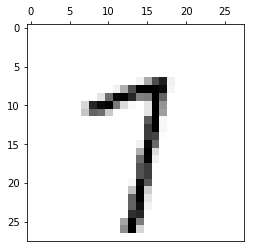

In [4]:
print(f'label of index 42 = {ltrain[42]}')
show(xtrain[:,42].reshape((28,28)))

## 3. The range and type of `xtrain`

In [5]:
print(f'range of xtrain = from {xtrain.min()} to {xtrain.max()}')
print(f'type of xtrain = {type(xtrain)}')

range of xtrain = from 0 to 255
type of xtrain = <class 'numpy.ndarray'>


## 4. Normalize `xtrain`
Normalize `xtrain` s.t. it is in the range `[-1,1]` of type `float32`.

In [6]:
def normalize_MNIST_images(x):
    '''
    Inputs:
        x: data
    '''
    x = x.astype(np.float32)
    #x = (x-128)/128
    x = x*2/255-1
    return x

In [7]:
xtrain = normalize_MNIST_images(xtrain)
print(f'min normalized xtrain = {normalize_MNIST_images(xtrain).min()}')
print(f'max normalized xtrain = {normalize_MNIST_images(xtrain).max()}')

min normalized xtrain = -1.0078431367874146
max normalized xtrain = -0.9921568632125854


## 5. One-hot encoding

In [8]:
def label2onehot(lbl):
    '''
    Convert label (n,) to onehot form (d,n).
    '''
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d

In [9]:
dtrain = label2onehot(ltrain)
print(f'dtrain shape = {dtrain.shape}')
print(f'{np.where(dtrain[:,42] == 1)}')
print(f'{np.where(dtrain[:,42] == 1) == ltrain[42]}')

dtrain shape = (10, 60000)
(array([7]),)
[[ True]]


## 6. One-hot decoding

In [10]:
def onehot2label(d):
    '''
    Inputs:
        d: one-hot encoding labels
    '''
    lbl = d.argmax(axis=0)
    return lbl

In [11]:
all(ltrain == onehot2label(dtrain))

True

## 7. The softmax function

In [12]:
def softmax(a):
    '''
    Inputs: 
        a: data
    '''
    exp_a = np.exp(a - np.max(a, axis=0))
    return exp_a / np.sum(exp_a, axis=0)

## 8. $$ 
\frac{\partial g(\boldsymbol{a})_i}{\partial a_i} = {g(\boldsymbol{a})}_i (1-{g(\boldsymbol{a})_i})
$$

Prof:

$$
\begin{align}
\frac{\partial g(\boldsymbol{a})_i}{\partial a_i} & = 
  \frac{\partial}{\partial a_i}\frac{e^{a_i}}{\Sigma_{k=1}^{N} e^{a_k}} \\
& = \frac{e^{a_i}\Sigma_{k=1}^{N}e^{a_k}-e^{a_i}e^{a_i}}{(\Sigma_{k=1}^{N}e^{a_k})^2} \\
& = \frac{e^{a_i}}{\Sigma_{k=1}^{N}e^{a_k}} \frac{\Sigma_{k=1}^{N}e^{a_k}-e^{a_i}}{\Sigma_{k=1}^{N}e^{a_k}} \\
& = {g(\boldsymbol{a})}_i (1-{g(\boldsymbol{a})_i})
\end{align}
$$

## Q9$$
\frac{\partial{g(\boldsymbol{a})_i}}{\partial a_j}=-g(\boldsymbol{a})_i g(\boldsymbol{a})_j \quad for \, j \neq i
$$

Prof:

$$
\begin{align}
\frac{\partial g(\boldsymbol{a})_i}{\partial a_j} & = 
  \frac{\partial}{\partial a_j} \frac{e^{a_i}}{\Sigma_{k=1}^{N} e^{a_k}} \\
& = \frac{0-e^{a_i}e^{a_j}}{(\Sigma_{k=1}^{N}e^{a_k})^2} \\
& = -\frac{e^{a_i}}{\Sigma_{k=1}^{N}e^{a_k}} \frac{e^{a_j}}{\Sigma_{k=1}^{N}e^{a_k}} \\
& = -{g(\boldsymbol{a})}_i g(\boldsymbol{a})_j
\end{align}
$$

## 10. Compute the $\delta$
$$
\delta = g(a)\otimes e-<g(a),e>g(a)
$$

In [13]:
def softmaxp(a, e):
    '''
    Compute delta for the backpropagation.
    
    Inputs:
        a: predictions before softmax
        e: onehot labels
        
    Returns:
        delta
    '''
    softmax_a = softmax(a)
    
    # element-wise product
    e_prod = softmax_a*e
    
    # dot product
    dot_prod = np.sum(e_prod, axis=0)
    
    return e_prod - dot_prod*softmax_a

# 11. Numerical approximations for $\delta\$
$$
\delta=\frac{\partial g(a)}{\partial a}\times e = \lim_{\epsilon \to 0}\frac{g(a+\epsilon e)-g(a)}{\epsilon}
$$

In [14]:
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
diff_approx = (softmax(a + eps*e) - softmax(a)) / eps
rel_error = np.abs(diff-diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

5.060518076321574e-07 should be smaller than 1e-6


## 12. ReLU and its directional derivative

In [15]:
def relu(a):
    return np.maximum(a, 0)

def relup(a, e):
    '''
    The directional derivative of the ReLU function.
    '''
    eps = 1e-6
    return (relu(a + eps * e) - relu(a)) / eps

## 13. Initialization of the net
Utilize `He and Xavier initializations`.

In [16]:
def init_shallow(Ni, Nh, No):
    '''
    Inputs:
        Ni: dimension of input layer
        Nh: dimension of output layer
        No: number of unit of output layer
    
    Returns:
        parameters of the net
    '''
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

In [17]:
Ni = xtrain.shape[0] # 784
Nh = 64
No = dtrain.shape[0] # 10
netinit = init_shallow(Ni, Nh, No)

## 14. Foward propagation

In [18]:
def forwardprop_shallow(x, net):
    '''
    Inputs:
        x: data
        net: parameters of the net
    
    Returns:
        prediction    
    '''
    W1 = net[0] # (64, 784)
    b1 = net[1] # (64, 1)
    W2 = net[2] # (10, 64)
    b2 = net[3] # (10, 1)
    
    a1 = W1.dot(x) + b1 # (64, 60000)
    h1 = relu(a1) # (64, 60000)
    
    a2 = W2.dot(h1) + b2 # (10, 60000)
    y = softmax(a2) # (10, 60000)
    return y

In [19]:
yinit = forwardprop_shallow(xtrain, netinit)

## 15. Loss

In [20]:
def eval_loss(y, d):
    '''
    Inputs:
        y (10, 60000): prediction
        d (10, 60000): ground truth
    
    Returns:
        Average cross-entropy loss (1, 1)
    '''
    return -np.sum(d*np.log(y))/y.shape[0]/y.shape[1]

In [21]:
print(eval_loss(yinit, dtrain), 'should be around .26')

0.2547464657471889 should be around .26


## 16. Error rate

In [22]:
def eval_perfs(y, lbl):
    '''
    Compute the percentage of misclassified samples.
    
    Inputs:
        y (10, 60000): prediction
        lbl (10, 60000): ground truth
    
    Returns:
        Error rate
    '''
    return np.sum(onehot2label(y)!=lbl)/lbl.size

In [23]:
print(eval_perfs(yinit, ltrain))

0.9184666666666667


## 17. Update the parameters 
Perform one backpropagation update for the network.

In [24]:
def update_shallow(x, d, net, gamma=.05):
    '''
    Inputs:
        x: data
        d: ground truth
        net: parameters of the net
        gamma: learning rate
    
    Returns:
        parameters of the net
    '''
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    
    # cross-entropy loss
    e = -d/y + (1-d)/(1-y)
    
    # backprop
    delta2 = softmaxp(a2, e)
    delta1 = relup(a1, W2.T.dot(delta2))
    
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis=1, keepdims=True)
    b1 = b1 - gamma * delta1.sum(axis=1, keepdims=True)
    
    return W1, b1, W2, b2

## 18. Backpropagation

In [25]:
def backprop_shallow(x, d, net, T, gamma=.05):
    '''
    Inputs:
        x: data
        d: ground truth
        net: parameters of the net
        T: number of updates
        gamma: learning rate
    
    Returns:
        parameters of the net
    '''
    lbl = onehot2label(d)
    for t in range(T):
        # COMPLETE TO UPDATE NET
        y = forwardprop_shallow(x, net)
        # COMPLETE TO DISPLAY LOSS AND PERFS
        net = update_shallow(x, d, net, gamma)
        print(f'\niter = {t+1}')
        print(f'loss = {eval_loss(y, d)}')
        print(f'error rate = {eval_perfs(y, lbl)}')
    return net

In [26]:
print('\niter_max = 100\n')
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)


iter_max = 100


iter = 1
loss = 0.2547464657471889
error rate = 0.9184666666666667

iter = 2
loss = 0.22466514643700308
error rate = 0.8190333333333333

iter = 3
loss = 0.2111696595608609
error rate = 0.7299333333333333

iter = 4
loss = 0.2016944092320122
error rate = 0.6583166666666667

iter = 5
loss = 0.19283483716593613
error rate = 0.61015

iter = 6
loss = 0.18527237195204466
error rate = 0.5602833333333334

iter = 7
loss = 0.17773047553957663
error rate = 0.5478

iter = 8
loss = 0.1716846185498394
error rate = 0.5100166666666667

iter = 9
loss = 0.1664138161788615
error rate = 0.5240833333333333

iter = 10
loss = 0.16411071592949647
error rate = 0.5234

iter = 11
loss = 0.16311409915218053
error rate = 0.5425166666666666

iter = 12
loss = 0.16103345862558532
error rate = 0.5521666666666667

iter = 13
loss = 0.15329554880276927
error rate = 0.48896666666666666

iter = 14
loss = 0.14449437840146387
error rate = 0.4634666666666667

iter = 15
loss = 0.13893315405690174
error rate = 

## 19.  Evaluate the performance on the testing dataset

In [27]:
print(f'xtest.shape = {xtest.shape}')
print(f'ltest.shape = {ltest.shape}')

xtest.shape = (784, 10000)
ltest.shape = (10000,)


In [28]:
# use trained network to test testing data
pred_test = forwardprop_shallow(xtest, nettrain)
print(f'error rate = {eval_perfs(pred_test, ltest)}')

error rate = 0.2598


## 20. Backpropagation based on minibatch gradient descent

In [29]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    '''
    Inputs:
        x: data
        d: ground truth
        net: parameters of net
        T: number of epoch
        B: minibatches
        gamma: learning rate
    
    Returns:
        parameters of net
    '''
    N = x.shape[1]
    NB = int((N+B-1)/B)
    lbl = onehot2label(d)
    for t in range(T):
        shuffled_indices = np.random.permutation(range(N))
        for l in range(NB):
            minibatch_indices = shuffled_indices[B*l:min(B*(l+1), N)]
            # COMPLETE TO UPDATE NET
            net = update_shallow(x[:,minibatch_indices], d[:,minibatch_indices], net, gamma)
        y = forwardprop_shallow(x, net)
        # COMPLETE TO DISPLAY LOSS AND PERFS
        print(f'\niter = {t+1}')
        print(f'loss = {eval_loss(y, d)}')
        print(f'error rate = {eval_perfs(y, lbl)}')
    return net

In [30]:
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)


iter = 1
loss = 0.02815563602741705
error rate = 0.08113333333333334

iter = 2
loss = 0.020712688598269982
error rate = 0.06015

iter = 3
loss = 0.016013350631276506
error rate = 0.045233333333333334

iter = 4
loss = 0.013688136894245998
error rate = 0.039233333333333335

iter = 5
loss = 0.012675420382414097
error rate = 0.036583333333333336


## 21. Evaluate the performance on the testing dataset based on network with minibatch

In [31]:
# use trained network to test testing data
pred_test_mini = forwardprop_shallow(xtest, netminibatch)
print(f'error rate = {eval_perfs(pred_test_mini, ltest)}')

error rate = 0.0499
